In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import norm, skew

from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
credit = pd.read_csv('./../data-set/credit_risk_dataset.csv')

In [3]:
credit.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
for i in range(len(credit.columns)):
    print(credit.iloc[:,i].name, credit.iloc[:,i].dtype)

print(credit.shape)

person_age int64
person_income int64
person_home_ownership object
person_emp_length float64
loan_intent object
loan_grade object
loan_amnt int64
loan_int_rate float64
loan_status int64
loan_percent_income float64
cb_person_default_on_file object
cb_person_cred_hist_length int64
(32581, 12)


In [5]:
na_data = credit.isnull().sum()
na_data_train = na_data.drop(na_data[na_data == 0].index).sort_values(ascending=False)
print(na_data_train)

loan_int_rate        3116
person_emp_length     895
dtype: int64


In [6]:
list_dummy = credit.select_dtypes("object").columns.tolist()
list_dummies = pd.get_dummies(credit[list_dummy])

In [7]:
credit_data = credit.select_dtypes(exclude=["object"])
credit_data = credit_data.fillna(credit_data.mean())
credit_data = pd.concat([credit_data, list_dummies], axis = 1)
credit_data = credit_data.fillna(0)

In [8]:
target_0 = 0
target_1 = 0

for i in range(len(credit_data.loan_status)):
    if credit_data.loan_status[i] == 0:
        target_0 += 1
    else:
        target_1 += 1

target_class = credit_data.loan_status.unique()
target_list =[target_1, target_0]

d = {'target':target_class, 'count':target_list}
target_g = pd.DataFrame(d)
target_g

,target,count
0,1,7108
1,0,25473


Text(0.5,1,'Total number of Target Instances')

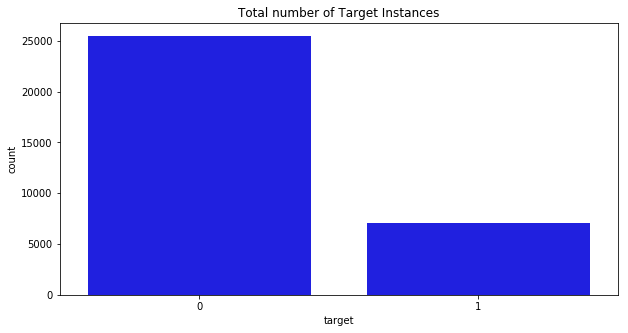

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x='target', y='count', data=target_g, color='b')
ax.set_title('Total number of Target Instances')

In [10]:
x = credit_data
x = x.drop(['loan_status'], axis=1)
y = credit_data.loan_status

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_res_train, y_res_train = sm.fit_resample(X_train, y_train)

In [11]:
scaling = Normalizer()
X_res_train = scaling.fit_transform(X_res_train)
X_test_norm = scaling.fit_transform(X_test)

Number of Samples Train:  35720
Number of Samples Test:  9775


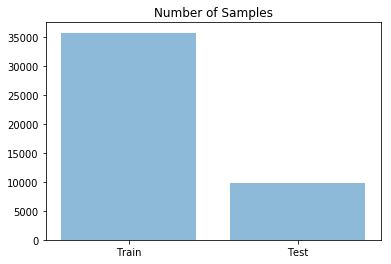

In [12]:
objects = ('Train', 'Test')
y_pos = np.arange(len(objects))
samples = []

samples.append(len(X_res_train))
samples.append(len(X_test_norm))

print("Number of Samples Train: ", samples[0]) 
print("Number of Samples Test: ", samples[1]) 

plt.bar(y_pos, samples, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Number of Samples')

plt.show()

In [13]:
logr = LogisticRegression(random_state=0)
logr.fit(X_res_train, y_res_train)

c:\users\tony\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
xg = XGBClassifier()
xg.fit(X_res_train, y_res_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [15]:
test_pred = logr.predict(X_test_norm)
accuracy_logr = logr.score(X_test_norm, y_test)

print("Accuracy of Logistic Regression classifier on test set: %.2f%%" % (accuracy_logr * 100.0))

y_pred = xg.predict(X_test_norm)
predictions = [round(value) for value in y_pred]
accuracy_xg = accuracy_score(y_test, predictions)

print("Accuracy of XGBoost classifier on test set: %.2f%%" % (accuracy_xg * 100.0))

Accuracy of Logistic Regression classifier on test set: 69.80%
Accuracy of XGBoost classifier on test set: 91.61%


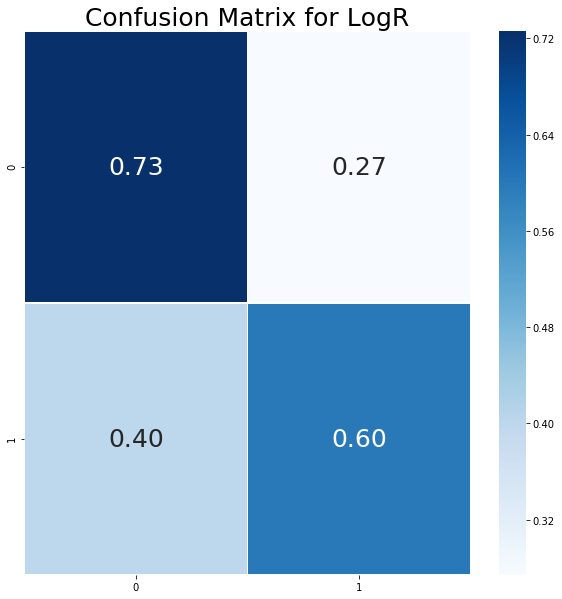

In [16]:
cm = confusion_matrix(y_test, test_pred) 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix for LogR', fontsize = 25)
sns.heatmap(cmn, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", annot_kws={"size": 25})

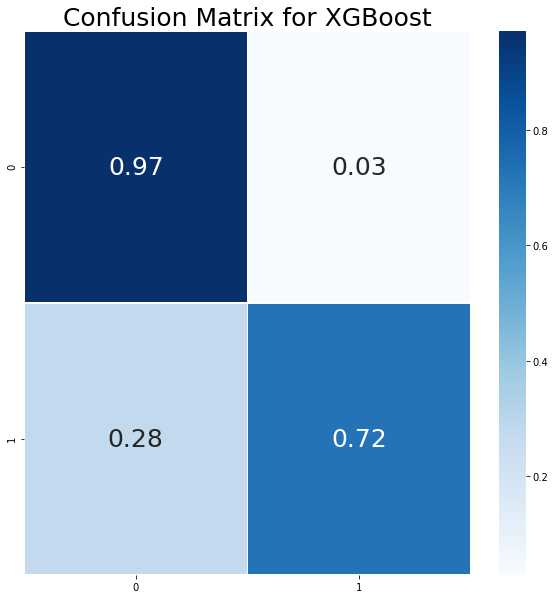

In [17]:
cm = confusion_matrix(y_test, predictions) 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix for XGBoost', fontsize = 25)
sns.heatmap(cmn, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", annot_kws={"size": 25})

In [18]:
print('Logistic Regression Report: \n', classification_report(y_test, test_pred),'\n')
print('XGBoost Report: \n', classification_report(y_test, y_pred))

Logistic Regression Report: 
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      7613
           1       0.38      0.60      0.47      2162

    accuracy                           0.70      9775
   macro avg       0.62      0.66      0.63      9775
weighted avg       0.76      0.70      0.72      9775
 

XGBoost Report: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7613
           1       0.87      0.72      0.79      2162

    accuracy                           0.92      9775
   macro avg       0.90      0.85      0.87      9775
weighted avg       0.91      0.92      0.91      9775



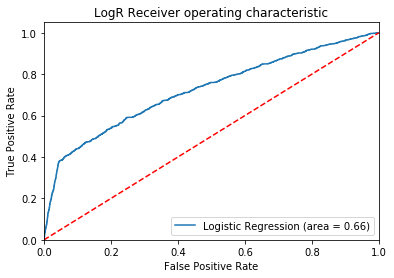

In [19]:
logit_roc_auc = roc_auc_score(y_test, logr.predict(X_test_norm))
fpr, tpr, thresholds = roc_curve(y_test, logr.predict_proba(X_test_norm)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogR Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

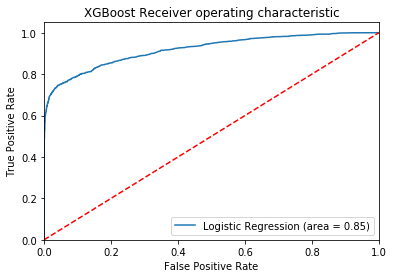

In [20]:
logit_roc_auc = roc_auc_score(y_test, xg.predict(X_test_norm))
fpr, tpr, thresholds = roc_curve(y_test, xg.predict_proba(X_test_norm)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [21]:
test_pred = logr.predict(X_test_norm)
test_pred_prob = logr.predict_proba(X_test_norm).T[1]
index = X_test.person_age
p_income = X_test.person_income

test_pred_table_logr = pd.DataFrame({'Age': index, 'Income': p_income, 
                                'loan_status_predict': test_pred, 'loan_status_probability': test_pred_prob*100})

In [31]:
print('LogR Prediction Table')
test_pred_table_logr = test_pred_table_logr.reset_index(drop=True)
test_pred_table_logr.to_csv('test_prediction_logr.csv')
print(test_pred_table_logr)

LogR Prediction Table
      Age  Income  loan_status_predict  loan_status_probability
0      24   28000                    1                78.588604
1      27   64000                    0                42.482224
2      26   72000                    1                55.584906
3      23   27996                    1                78.595022
4      30   44500                    1                68.676680
5      25   63000                    1                72.831963
6      26   27031                    1                55.559512
7      30   40000                    0                26.187391
8      26   90000                    0                33.298395
9      35   41235                    0                27.741457
10     21   26400                    0                47.163945
11     26   59500                    1                51.491910
12     39  134000                    0                48.462745
13     22   60000                    1                84.096524
14     23   32000 

In [27]:
test_pred_xg = xg.predict(X_test_norm)
test_pred_prob_xg = xg.predict_proba(X_test_norm).T[1]
index = X_test.person_age
p_income = X_test.person_income

test_pred_table_xg = pd.DataFrame({'Age': index, 'Income': p_income, 
                                'loan_status_predict': test_pred_xg, 'loan_status_probability': test_pred_prob_xg*100})

In [32]:
print('LogR Prediction Table')
test_pred_table_xg = test_pred_table_xg.reset_index(drop=True)
test_pred_table_xg.to_csv('test_prediction_xg.csv')
print(test_pred_table_xg)

LogR Prediction Table
      Age  Income  loan_status_predict  loan_status_probability
0      24   28000                    0                18.297794
1      27   64000                    0                18.124834
2      26   72000                    0                26.432068
3      23   27996                    1                98.049362
4      30   44500                    1                75.986000
5      25   63000                    0                26.587645
6      26   27031                    0                18.567739
7      30   40000                    0                 5.379700
8      26   90000                    0                17.081354
9      35   41235                    0                 4.308392
10     21   26400                    0                34.807335
11     26   59500                    0                 3.222669
12     39  134000                    0                 3.172504
13     22   60000                    0                29.171177
14     23   32000 